In [1]:
import torch
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision
import pandas as pd
import torchvision.utils as vutils
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp '/content/gdrive/My Drive/Diss/Yu/train_data.zip' '/content/train_data.zip'

In [ ]:
!unzip 'train_data.zip'

Archive:  train_data.zip
replace train_data/gan_3_img_6719.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
import sys
sys.path.append('/content/gdrive/My Drive/')
import model_architectures as ma
import fp_utilities as fp_util

# **Autoencoder Training**

In [ ]:
partition = {}
partition['training data'] = ['{}_img_{}'.format(source, num) for source in ['gan_1','gan_2','gan_3','real'] for num in range(1,10001)]
partition['validation data'] = ['{}_img_{}'.format(source, num) for source in ['gan_1','gan_2','gan_3','real'] for num in range(10001,15001)]

In [ ]:
img_to_labels_dict = {}
label_mapping = {'real':0, 'gan_1':1, 'gan_2':2, 'gan_3':3}
for num in range(1,150001):
  for source in label_mapping.keys():
    img_to_labels_dict['{}_img_{}'.format(source,num)] = label_mapping[source]

In [ ]:
class AutoEncoderDataset(torch.utils.data.Dataset):
  def __init__(self, list_IDs, labels):
        self.labels = labels
        self.list_IDs = list_IDs

  def __len__(self):
        return len(self.list_IDs)

  def __getitem__(self, index):
        ID = self.list_IDs[index]
        img = torch.from_numpy(np.load('/content/train_data/' + ID + '.npy'))
      
        label = self.labels[ID]

        return img, label

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
autoEnc = ma.Autoencoder()
autoEnc.to(device)


Autoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convTr1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (convTr2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)

In [ ]:
manualSeed = 650

torch.manual_seed(manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)

#initialise the learned fingerprints as random vectors
real_fp = torch.randn(784, requires_grad=True, device=device)
gan1_fp = torch.randn(784, requires_grad=True, device=device)
gan2_fp = torch.randn(784, requires_grad=True, device=device)
gan3_fp = torch.randn(784, requires_grad=True, device = device)
fps = [real_fp, gan1_fp, gan2_fp, gan3_fp]

In [ ]:
from itertools import chain
optimizer = optim.Adam(chain(autoEnc.parameters(), iter(fps)))

In [ ]:
# implementation of the loss component termed L_cls in the dissertation
def custom_loss(output, target, source):

  output_vec = torch.reshape(output, (-1, 784)) #flatten batch of matrices to batch of vectors
  target_vec = torch.reshape(target, (-1, 784)) #flatten batch of matrices to batch of vectors
  img_fps_vec = target_vec - output_vec     #get fingerprint
  img_fps_vec_norm = F.normalize(img_fps_vec - torch.mean(img_fps_vec, dim=1).unsqueeze(1), dim=1) #normalize fingerprint for each image in batch
  fps_vec_norm = [F.normalize(fp - torch.mean(fp), dim=0) for fp in fps] #normalize each model fingerprint
  cov_vecs = [(torch.mv(img_fps_vec_norm, fp_vec_norm)) for fp_vec_norm in fps_vec_norm] #get covariance of each image with each fingerprint
  ce_loss_criterion = nn.CrossEntropyLoss()
  ce_loss = ce_loss_criterion(torch.stack(cov_vecs, dim=1), source) 
  return ce_loss
  

In [ ]:
params = {'batch_size': 256,
          'shuffle': True,
          'num_workers': 6}

#separate data into training and validation sets

training_set = AutoEncoderDataset(partition['training data'], img_to_labels_dict)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = AutoEncoderDataset(partition['validation data'], img_to_labels_dict)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
#track loss values at the end of every epoch for early stopping

mse_train_losses = []
fp_train_losses = []
mse_val_losses = []
fp_val_losses = []

mseCriterion = nn.MSELoss()

In [ ]:
def train_autoenc(start_epoch, end_epoch):
  for epoch in range(start_epoch, end_epoch):
    print("Starting epoch {}".format(epoch))
    # Training
    mse_loss_sum = 0
    fp_loss_sum = 0
    for i, (local_batch, local_labels) in enumerate(training_generator):

        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        optimizer.zero_grad()
        output = autoEnc(local_batch)
        
        mse_loss = mseCriterion(output, local_batch)
        fp_loss = custom_loss(output, local_batch, local_labels)

        cum_loss = 5*mse_loss + 2*fp_loss
        cum_loss.backward()
        optimizer.step()

        mse_loss_sum += mse_loss.item()
        fp_loss_sum += fp_loss.item()
        if i % 50 == 0:
          print('[%d/%d][%d/%d]\tTrain Reconstruction Loss %.4f\t Train Correlation Loss %.4f'
          % (epoch, end_epoch, i, len(training_generator), mse_loss.item(), fp_loss.item()))
      
    mse_train_losses.append(mse_loss_sum/len(training_generator))
    fp_train_losses.append(fp_loss_sum//len(training_generator))

    # Validation
    mse_loss_sum = 0
    fp_loss_sum = 0
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in validation_generator:
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            output = autoEnc(local_batch)

            mse_loss = mseCriterion(output, local_batch)
            fp_loss = custom_loss(output, local_batch, local_labels)

            mse_loss_sum += mse_loss.item()
            fp_loss_sum += fp_loss.item()

    avg_mse_loss = mse_loss_sum/len(validation_generator)
    avg_fp_loss = fp_loss_sum/len(validation_generator)
    print("Val Reconstruction Loss %.4f\t Val Correlation Loss %.4f"%(avg_mse_loss, avg_fp_loss))
    mse_val_losses.append(avg_mse_loss)
    fp_val_losses.append(avg_fp_loss)

In [ ]:
def create_checkpoint():
  torch.save({
            'model_state_dict': autoEnc.state_dict(),
            'optim_state_dict': optimizer.state_dict(),
            'mse_train_losses': mse_train_losses,
            'fp_train_losses': fp_train_losses,
            'mse_val_losses': mse_val_losses,
            'fp_val_losses': fp_val_losses
            }, 'gdrive/My Drive/Diss/trained_models/Autoencoder')
  np.save('gdrive/My Drive/Diss/Yu/Fingerprints/print_real', real_fp.to('cpu').detach().numpy())
  np.save('gdrive/My Drive/Diss/Yu/Fingerprints/print_GAN_1', gan1_fp.to('cpu').detach().numpy())
  np.save('gdrive/My Drive/Diss/Yu/Fingerprints/print_GAN_2', gan2_fp.to('cpu').detach().numpy())
  np.save('gdrive/My Drive/Diss/Yu/Fingerprints/print_GAN_3', gan3_fp.to('cpu').detach().numpy())

In [ ]:
train_autoenc(0, 100)

Starting epoch 0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[0/100][0/157]	Train Reconstruction Loss 0.1610	 Train Correlation Loss 1.3865
[0/100][50/157]	Train Reconstruction Loss 0.1419	 Train Correlation Loss 1.3865
[0/100][100/157]	Train Reconstruction Loss 0.0975	 Train Correlation Loss 1.3851
[0/100][150/157]	Train Reconstruction Loss 0.0482	 Train Correlation Loss 1.3859
Val Reconstruction Loss 0.0445	 Val Correlation Loss 1.3851
Starting epoch 1
[1/100][0/157]	Train Reconstruction Loss 0.0433	 Train Correlation Loss 1.3837
[1/100][50/157]	Train Reconstruction Loss 0.0281	 Train Correlation Loss 1.3828
[1/100][100/157]	Train Reconstruction Loss 0.0237	 Train Correlation Loss 1.3814
[1/100][150/157]	Train Reconstruction Loss 0.0220	 Train Correlation Loss 1.3818
Val Reconstruction Loss 0.0218	 Val Correlation Loss 1.3811
Starting epoch 2
[2/100][0/157]	Train Reconstruction Loss 0.0222	 Train Correlation Loss 1.3785
[2/100][50/157]	Train Reconstruction Loss 0.0203	 Train Correlation Loss 1.3788
[2/100][100/157]	Train Reconstruction Loss 0.

In [ ]:
create_checkpoint()

In [ ]:
train_autoenc(100,150)

Starting epoch 100


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[100/150][0/157]	Train Reconstruction Loss 0.0329	 Train Correlation Loss 1.1122
[100/150][50/157]	Train Reconstruction Loss 0.0321	 Train Correlation Loss 1.1391
[100/150][100/157]	Train Reconstruction Loss 0.0326	 Train Correlation Loss 1.1267
[100/150][150/157]	Train Reconstruction Loss 0.0315	 Train Correlation Loss 1.1210
Val Reconstruction Loss 0.0327	 Val Correlation Loss 1.1319
Starting epoch 101
[101/150][0/157]	Train Reconstruction Loss 0.0328	 Train Correlation Loss 1.1243
[101/150][50/157]	Train Reconstruction Loss 0.0323	 Train Correlation Loss 1.1427
[101/150][100/157]	Train Reconstruction Loss 0.0328	 Train Correlation Loss 1.1305
[101/150][150/157]	Train Reconstruction Loss 0.0328	 Train Correlation Loss 1.1274
Val Reconstruction Loss 0.0331	 Val Correlation Loss 1.1345
Starting epoch 102
[102/150][0/157]	Train Reconstruction Loss 0.0325	 Train Correlation Loss 1.1422
[102/150][50/157]	Train Reconstruction Loss 0.0320	 Train Correlation Loss 1.1355
[102/150][100/157]	Tr

In [ ]:
create_checkpoint()

In [ ]:
train_autoenc(150,200)

Starting epoch 150


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[150/200][0/157]	Train Reconstruction Loss 0.0351	 Train Correlation Loss 1.0771
[150/200][50/157]	Train Reconstruction Loss 0.0362	 Train Correlation Loss 1.0813
[150/200][100/157]	Train Reconstruction Loss 0.0374	 Train Correlation Loss 1.0911
[150/200][150/157]	Train Reconstruction Loss 0.0363	 Train Correlation Loss 1.0828
Val Reconstruction Loss 0.0355	 Val Correlation Loss 1.0842
Starting epoch 151
[151/200][0/157]	Train Reconstruction Loss 0.0358	 Train Correlation Loss 1.0750
[151/200][50/157]	Train Reconstruction Loss 0.0367	 Train Correlation Loss 1.0875
[151/200][100/157]	Train Reconstruction Loss 0.0363	 Train Correlation Loss 1.0781
[151/200][150/157]	Train Reconstruction Loss 0.0340	 Train Correlation Loss 1.0939
Val Reconstruction Loss 0.0356	 Val Correlation Loss 1.0871
Starting epoch 152
[152/200][0/157]	Train Reconstruction Loss 0.0348	 Train Correlation Loss 1.0954
[152/200][50/157]	Train Reconstruction Loss 0.0364	 Train Correlation Loss 1.0728
[152/200][100/157]	Tr

In [ ]:
create_checkpoint()

In [ ]:
train_autoenc(200,250)

Starting epoch 200


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[200/250][0/157]	Train Reconstruction Loss 0.0374	 Train Correlation Loss 1.0498
[200/250][50/157]	Train Reconstruction Loss 0.0375	 Train Correlation Loss 1.0639
[200/250][100/157]	Train Reconstruction Loss 0.0364	 Train Correlation Loss 1.0567
[200/250][150/157]	Train Reconstruction Loss 0.0366	 Train Correlation Loss 1.0540
Val Reconstruction Loss 0.0372	 Val Correlation Loss 1.0588
Starting epoch 201
[201/250][0/157]	Train Reconstruction Loss 0.0360	 Train Correlation Loss 1.0547
[201/250][50/157]	Train Reconstruction Loss 0.0376	 Train Correlation Loss 1.0458
[201/250][100/157]	Train Reconstruction Loss 0.0368	 Train Correlation Loss 1.0544
[201/250][150/157]	Train Reconstruction Loss 0.0385	 Train Correlation Loss 1.0622
Val Reconstruction Loss 0.0371	 Val Correlation Loss 1.0579
Starting epoch 202
[202/250][0/157]	Train Reconstruction Loss 0.0367	 Train Correlation Loss 1.0534
[202/250][50/157]	Train Reconstruction Loss 0.0357	 Train Correlation Loss 1.0602
[202/250][100/157]	Tr

In [ ]:
create_checkpoint()

In [ ]:
train_autoenc(250,300)

Starting epoch 250


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[250/300][0/157]	Train Reconstruction Loss 0.0391	 Train Correlation Loss 1.0322
[250/300][50/157]	Train Reconstruction Loss 0.0384	 Train Correlation Loss 1.0370
[250/300][100/157]	Train Reconstruction Loss 0.0386	 Train Correlation Loss 1.0420
[250/300][150/157]	Train Reconstruction Loss 0.0371	 Train Correlation Loss 1.0304
Val Reconstruction Loss 0.0384	 Val Correlation Loss 1.0477
Starting epoch 251
[251/300][0/157]	Train Reconstruction Loss 0.0383	 Train Correlation Loss 1.0547
[251/300][50/157]	Train Reconstruction Loss 0.0376	 Train Correlation Loss 1.0449
[251/300][100/157]	Train Reconstruction Loss 0.0391	 Train Correlation Loss 1.0379
[251/300][150/157]	Train Reconstruction Loss 0.0366	 Train Correlation Loss 1.0493
Val Reconstruction Loss 0.0386	 Val Correlation Loss 1.0416
Starting epoch 252
[252/300][0/157]	Train Reconstruction Loss 0.0392	 Train Correlation Loss 1.0348
[252/300][50/157]	Train Reconstruction Loss 0.0376	 Train Correlation Loss 1.0334
[252/300][100/157]	Tr

In [ ]:
create_checkpoint()

# **Visualise Learned Fingeprints**

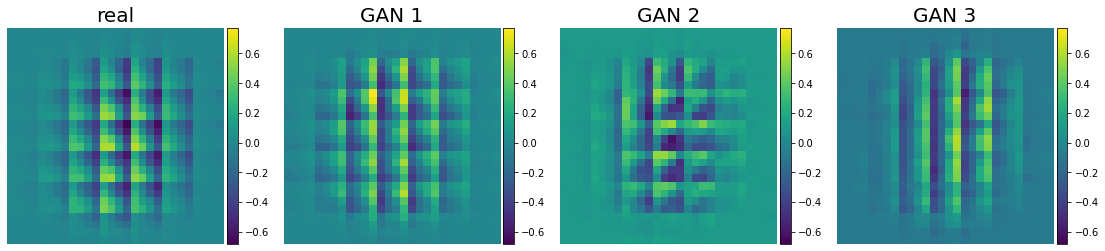

In [ ]:
plot_util.plot_fingerprints('Yu')

# **Investigate similarity between fingerprints**

In [ ]:
#calculate pairwise Pearson correlation coefficients between fingerprints
fps = fp_util.load_fingerprints('Yu')
fps_vectorised = np.reshape(fps, (4,-1))
np.corrcoef(fps_vectorised)

array([[ 1.        , -0.92077759,  0.12037477, -0.7580798 ],
       [-0.92077759,  1.        , -0.39481841,  0.80243455],
       [ 0.12037477, -0.39481841,  1.        , -0.68748347],
       [-0.7580798 ,  0.80243455, -0.68748347,  1.        ]])

# **Plot loss evolution graphs**

In [ ]:
autoEnc_dict = torch.load('/content/gdrive/My Drive/Diss/trained_models/Autoencoder', map_location=torch.device('cpu'))

fp_train_losses = autoEnc_dict['fp_train_losses']
fp_val_losses = autoEnc_dict['fp_val_losses']
mse_train_losses = autoEnc_dict['mse_train_losses']
mse_val_losses = autoEnc_dict['mse_val_losses']

total_train_losses = [sum(i) for i in zip([2*e for e in fp_train_losses], [5*e for e in mse_train_losses])]
total_val_losses = [sum(i) for i in zip([2*e for e in fp_val_losses], [5*e for e in mse_val_losses])]

In [ ]:
def plot_loss_evolution(ax, train_losses, val_losses, loss_type):
  ax.plot(train_losses, label = "Train Loss")
  ax.plot(val_losses, label = "Validation Loss")

  ax.set_xlabel("Number of Epochs")
  ax.set_ylabel(loss_type )
  ax.legend()

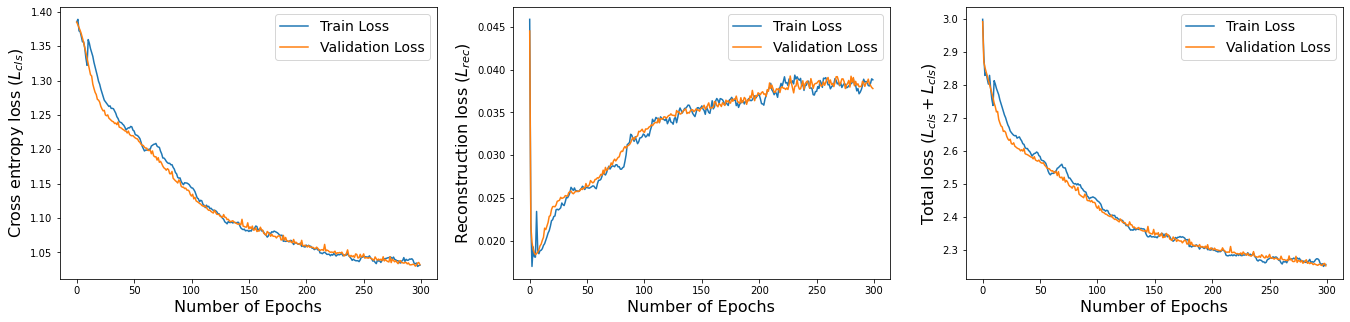

In [ ]:
plt.rcParams['axes.labelsize'] =  16
plt.rcParams['legend.fontsize']  =  14
plt.rcParams['text.usetex'] = False

fig, ax = plt.subplots(1,3, figsize = (23,5))
plot_loss_evolution(ax[0], fp_train_losses, fp_val_losses, 'Cross entropy loss ($L_{cls}$)')
plot_loss_evolution(ax[1], mse_train_losses, mse_val_losses, 'Reconstruction loss ($L_{rec}$)')
plot_loss_evolution(ax[2], total_train_losses, total_val_losses, 'Total loss ($L_{cls} + L_{cls}$)')

plt.savefig('autoenc_losses.pdf', bbox_inches = 'tight')

# **Get Autoencoder reconstructions for Appendix**

In [55]:
import random

start_index = random.randint(0,995)
num_samples = 5

real_imgs = fp_util.load_test_images(0)[start_index: start_index+num_samples]
gan1_imgs = fp_util.load_test_images(1)[start_index: start_index+num_samples]
gan2_imgs = fp_util.load_test_images(2)[start_index: start_index+num_samples]
gan3_imgs = fp_util.load_test_images(3)[start_index: start_index+num_samples]

In [48]:
def plot_autoencoded_images(original_imgs):
  num_samples = len(original_imgs)
  fig, ax = plt.subplots(2, num_samples, figsize=(10,4))
  
  autoencoder_output = fp_util.autoEnc(torch.from_numpy(original_imgs.reshape(num_samples,1,28,28))).detach().numpy().reshape(num_samples,28,28)

  for i in range(num_samples):
    ax[0,i].imshow(original_imgs[i])
    ax[0,i].axis('off')

    ax[1,i].imshow(autoencoder_output[i])
    ax[1,i].axis('off')


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


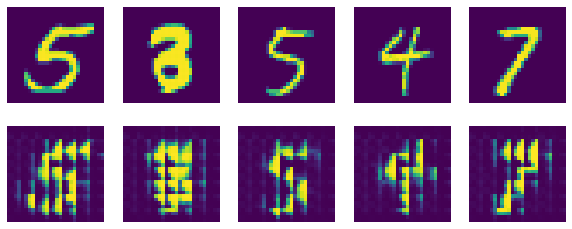

In [61]:
plot_autoencoded_images(real_imgs)
plt.savefig('real_imgs_autoenc.png', bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


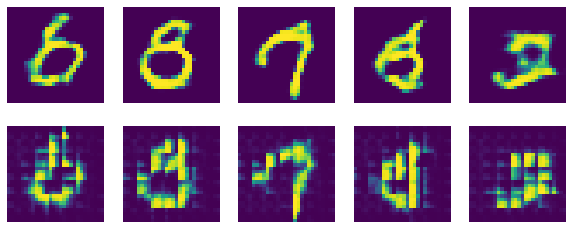

In [62]:
plot_autoencoded_images(gan1_imgs)
plt.savefig('gan1_imgs_autoenc.png', bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


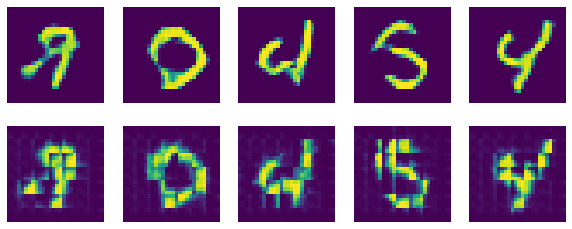

In [63]:
plot_autoencoded_images(gan2_imgs)
plt.savefig('gan2_imgs_autoenc.png', bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


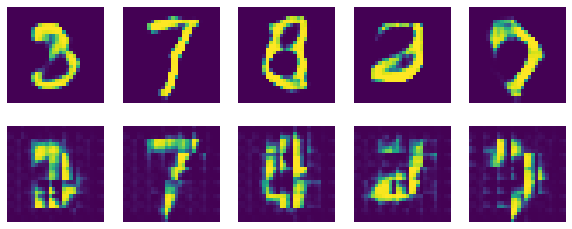

In [64]:
plot_autoencoded_images(gan3_imgs)
plt.savefig('gan3_imgs_autoenc.png', bbox_inches='tight')